## Modelos de Aprendizaje Automático

Cargamos las librerías necesarias y el dataframe previamente construido. Definimos también dos funciones auxiliares que usaremos.

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score,get_scorer
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
import xgboost as xgb

def calcula_metricas(y_true, y_pred):
    tn,fp,fn,tp = confusion_matrix(y_true, y_pred).ravel()
    sensitividad = tp/(fn+tp)
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    especificidad = tn / (tn + fp)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    f1 = 2 * (precision * sensitividad) / (precision + sensitividad) if (precision + sensitividad) != 0 else 0
    print("Accuracy:", accuracy)
    print("Sensitividad:", sensitividad)
    print("Especificidad:", especificidad)
    print("F1 Score:", f1)

def ajusta(param_grid,classifier,name_classifier,scorer,X_train,y_train,X_test,y_test,scoring,cv = 5):
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring=scorer, cv=cv)
    grid.fit(X_train, y_train)
    val_score = grid.best_score_
    best_model = grid.best_estimator_
    
    test_scorer = get_scorer(scorer)
    test_score = test_scorer(best_model, X_test, y_test)

    if name_classifier not in scoring or test_score > scoring[name_classifier]:
        scoring[name_classifier] = test_score

    print(f"[{name_classifier}] Validación cruzada (media): {val_score:.4f}")
    print(f"[{name_classifier}] Resultado en test: {test_score:.4f}")
    print(grid.best_params_)
    
    return best_model

In [57]:
df = pd.read_csv('data/out.csv')

In [59]:
df.head()

,popularity_level,degree,betweennes,closeness,eigenvector,clustering
0,1,0.002809,0.000086,0.318572,0.005886,0.111111
1,1,0.012638,0.002468,0.370180,0.043645,0.122222
2,1,0.019348,0.016555,0.339355,0.027648,0.063729
3,1,0.005149,0.001371,0.304206,0.011840,0.193182
4,0,0.001872,0.000031,0.310888,0.004246,0.181818


In [61]:
X = df.drop(columns='popularity_level')
y = df['popularity_level']

popularity_level
0    3632
1    2778
Name: count, dtype: int64


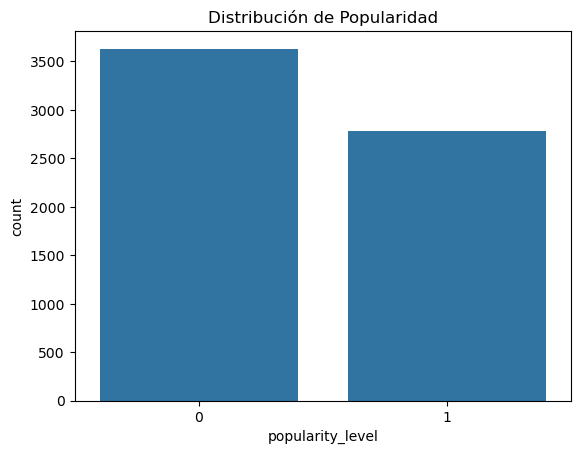

In [63]:
print(y.value_counts())
sns.countplot(x='popularity_level', data=df)
plt.title("Distribución de Popularidad")
plt.show()

Vemos que pese a la elección de los nodos para la creación del dataframe hay mayor presencia de artistas no populares. El objetivo de los modelos va a ser lograr predecir si un artista es popular, pues es lo menos común. Por ello, vamos a ver si debemos realizar ciertas técnicas para llevar a cabo una mejor predicción de la clase de interés.

Procedamos a realizar un modelo simple de Árboles de Clasificación para ver como se ajusta al conjunto de datos.

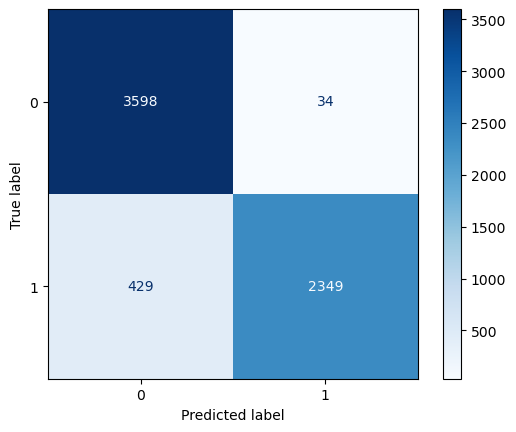

In [66]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)
y_pred = clf.predict(X)
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')

In [67]:
calcula_metricas(y,y_pred)

Accuracy: 0.9277691107644306
Sensitividad: 0.8455723542116631
Especificidad: 0.9906387665198237
F1 Score: 0.9102887037395854


El ajuste sobre el propio conjunto de entrenamiento tiene mayores problemas para predecir la clase de interés. En lo que sigue, usaremos la sensitividad (recall) para elegir los modelos. 

In [71]:
scorer = make_scorer(recall_score)
scoring = {}

Dividimos el dataframe en entrenamiento y test.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

A continuación vamos a llevar a cabo modelos de predicción del nivel de popularidad. Para ellos, vamos a encontrar el mejor modelo para los posibles valores de los hiperparámetros que se le proporcionamos. 

#### Predicción mediante Árboles de Decisión

In [78]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}
clf = ajusta(param_grid,tree.DecisionTreeClassifier(),'DTC',scorer,X_train, y_train,X_test, y_test,scoring,cv = 5)

[DTC] Validación cruzada (media): 0.5684
[DTC] Resultado en test: 0.5282
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [79]:
calcula_metricas(y_test, clf.predict(X_test))

Accuracy: 0.6731669266770671
Sensitividad: 0.5282331511839709
Especificidad: 0.781718963165075
F1 Score: 0.5805805805805807


[Text(0.5, 0.875, 'x[0] <= 0.001\nentropy = 1.0\nsamples = 5128\nvalue = [2564.0, 2564.0]'),
 Text(0.25, 0.625, 'x[0] <= 0.0\nentropy = 0.956\nsamples = 3566\nvalue = [2150.081, 1305.581]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[4] <= 0.5\nentropy = 0.899\nsamples = 1977\nvalue = [1291.287, 594.701]'),
 Text(0.0625, 0.125, 'entropy = 0.882\nsamples = 1586\nvalue = [1054.256, 453.215]'),
 Text(0.1875, 0.125, 'entropy = 0.954\nsamples = 391\nvalue = [237.031, 141.486]'),
 Text(0.375, 0.375, 'x[3] <= 0.005\nentropy = 0.994\nsamples = 1589\nvalue = [858.794, 710.88]'),
 Text(0.3125, 0.125, 'entropy = 0.989\nsamples = 1450\nvalue = [800.421, 626.909]'),
 Text(0.4375, 0.125, 'entropy = 0.977\nsamples = 139\nvalue = [58.373, 83.971]'),
 Text(0.75, 0.625, 'x[0] <= 0.004\nentropy = 0.807\nsamples = 1562\nvalue = [413.919, 1258.419]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[1] <= 0.0\nentropy = 0.911\nsamples = 887\nvalue = [303.364, 625.759]'),
 Text(0.5625, 0.125,

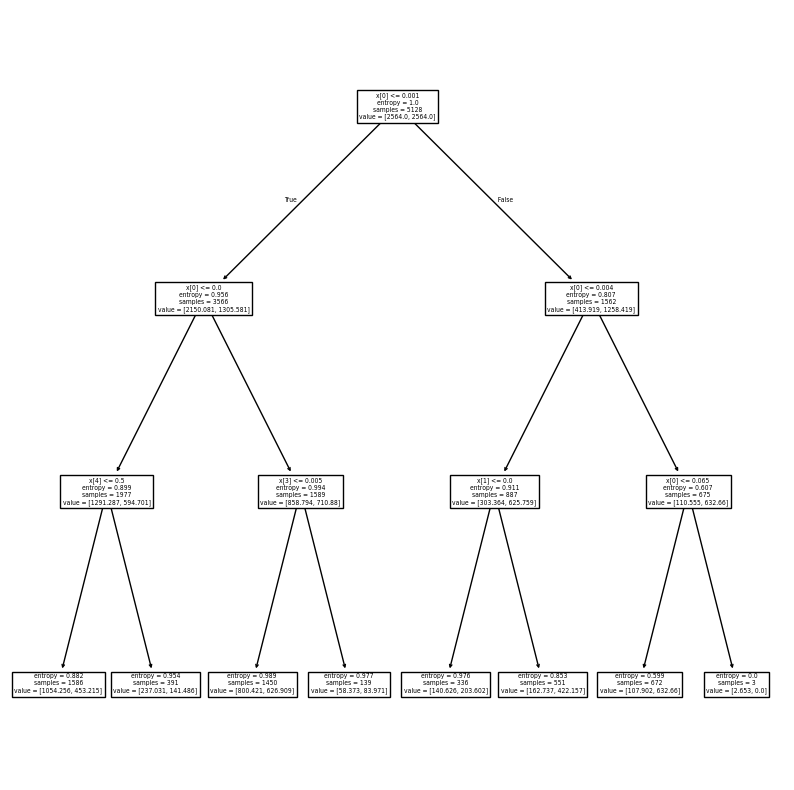

In [80]:
plt.figure(figsize= (10,10))
tree.plot_tree(clf)

Podríamos variar el umbral de probabilidad de clasificación de la clase positiva para obtener mejores resultados para la clase de interés, aunque sacrificando el accuracy.

In [82]:
y_proba = clf.predict_proba(X_test)[:, 1] 
umbral = 0.4 
y_pred_adjusted = (y_proba > umbral).astype(int)
calcula_metricas(y_test, y_pred_adjusted)

Accuracy: 0.6021840873634945
Sensitividad: 0.7668488160291439
Especificidad: 0.47885402455661663
F1 Score: 0.6227810650887574


#### Predicción mediante Bosques Aleatorios

In [84]:
param_grid = { 'n_estimators': [3, 5, 7, 10, 15],
              'max_depth': [5,10,15,20],
              'min_samples_split': [2, 5, 10],
              'class_weight': ['balanced']
             }
rfc = ajusta(param_grid,RandomForestClassifier(),'RFC',scorer,X_train, y_train,X_test, y_test,scoring,cv = 5)

[RFC] Validación cruzada (media): 0.5509
[RFC] Resultado en test: 0.5501
{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}


In [85]:
calcula_metricas(y_test, rfc.predict(X_test))

Accuracy: 0.671606864274571
Sensitividad: 0.5500910746812386
Especificidad: 0.762619372442019
F1 Score: 0.5892682926829268


In [86]:
param_grid = { 'n_estimators': [15,20,25,30],
              'max_depth': [13,15,17],
              'min_samples_split': [4,5,6],
              'class_weight': ['balanced']
             }
rfc = ajusta(param_grid,RandomForestClassifier(),'RFC',scorer,X_train, y_train,X_test, y_test,scoring,cv = 5)

[RFC] Validación cruzada (media): 0.5500
[RFC] Resultado en test: 0.5373
{'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 25}


In [87]:
calcula_metricas(y_test, rfc.predict(X_test))

Accuracy: 0.6365054602184087
Sensitividad: 0.5373406193078324
Especificidad: 0.7107776261937244
F1 Score: 0.5587121212121211


Igualmente, podemos variar el umbral de probabilidad.

In [89]:
y_proba = rfc.predict_proba(X_test)[:, 1] 
umbral = 0.4 
y_pred_adjusted = (y_proba > umbral).astype(int)
calcula_metricas(y_test, y_pred_adjusted)

Accuracy: 0.6201248049921997
Sensitividad: 0.6666666666666666
Especificidad: 0.5852660300136425
F1 Score: 0.6004922067268252


#### Predicción mediante XGBoost

In [91]:
param_grid = {
    'n_estimators': [10,20,30],               
    'max_depth': [3, 5, 7, 10],                
    'learning_rate': [0.01, 0.1, 0.2],         
    'scale_pos_weight': [1.0, 1.3]       
}

xgb_model1 = ajusta(param_grid,xgb.XGBClassifier(),'XGB1',scorer,X_train, y_train,X_test, y_test,scoring,cv = 5)

[XGB1] Validación cruzada (media): 0.5500
[XGB1] Resultado en test: 0.5647
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 30, 'scale_pos_weight': 1.3}


In [92]:
calcula_metricas(y_test, xgb_model1.predict(X_test))

Accuracy: 0.6739469578783152
Sensitividad: 0.5646630236794171
Especificidad: 0.7557980900409277
F1 Score: 0.5973025048169556


In [93]:
xgb_model1.n_estimators,xgb_model1.max_depth,xgb_model1.learning_rate,xgb_model1.scale_pos_weight

(30, 3, 0.1, 1.3)

In [94]:
param_grid = {
    'n_estimators': [25,30,35],               
    'max_depth': [2,3,4],                
    'learning_rate': [0.08,0.1, 0.12],         
    'scale_pos_weight': [1.2,1.3,1.4]       
}

xgb_model2 = ajusta(param_grid,xgb.XGBClassifier(),'XGB2',scorer,X_train, y_train,X_test, y_test,scoring,cv = 5)

[XGB2] Validación cruzada (media): 0.5796
[XGB2] Resultado en test: 0.5883
{'learning_rate': 0.12, 'max_depth': 3, 'n_estimators': 35, 'scale_pos_weight': 1.4}


In [95]:
calcula_metricas(y_test, xgb_model2.predict(X_test))

Accuracy: 0.671606864274571
Sensitividad: 0.5883424408014571
Especificidad: 0.7339699863574352
F1 Score: 0.6054358013120898


In [96]:
xgb_model2.n_estimators,xgb_model2.max_depth,xgb_model2.learning_rate,xgb_model2.scale_pos_weight

(35, 3, 0.12, 1.4)

In [97]:
param_grid = {
    'n_estimators': [35,40,45],               
    'max_depth': [3],                
    'learning_rate': [0.12,0.14,0.16,0.18],         
    'scale_pos_weight': [1.4,1.5,1.6]        
}

xgb_model3 = ajusta(param_grid,xgb.XGBClassifier(),'XGB3',scorer,X_train, y_train,X_test, y_test,scoring,cv = 5)

[XGB3] Validación cruzada (media): 0.6357
[XGB3] Resultado en test: 0.6339
{'learning_rate': 0.18, 'max_depth': 3, 'n_estimators': 40, 'scale_pos_weight': 1.6}


In [98]:
calcula_metricas(y_test, xgb_model3.predict(X_test))

Accuracy: 0.6630265210608425
Sensitividad: 0.6338797814207651
Especificidad: 0.684856753069577
F1 Score: 0.6170212765957447


In [99]:
xgb_model3.n_estimators,xgb_model3.max_depth,xgb_model3.learning_rate,xgb_model3.scale_pos_weight

(40, 3, 0.18, 1.6)

Realicemos una última búsqueda. Notar que debido a que buscamos la solución con una mejor sensitividad, el modelo va a ser mejor cuanto mayor sea el parámetro `scale_pos_weight`. Para evitar el sesgo del modelo hacia la clase positiva, vamos a tomarlo como $1.6$.

In [103]:
param_grid = {
    'n_estimators': [38,39,40,42,43,44],               # número de árboles
    'max_depth': [3],                # profundidad máxima del árbol
    'learning_rate': [0.17,0.18,0.19,0.2],         # tasa de aprendizaje
    'scale_pos_weight': [1.6]        # útil si las clases están desbalanceadas (valor de 1.3 aprox. por tu distribución)
}

xgb_model4 = ajusta(param_grid,xgb.XGBClassifier(),'XGB4',scorer,X_train, y_train,X_test, y_test,scoring,cv = 5)

[XGB4] Validación cruzada (media): 0.6357
[XGB4] Resultado en test: 0.6321
{'learning_rate': 0.18, 'max_depth': 3, 'n_estimators': 38, 'scale_pos_weight': 1.6}


In [104]:
calcula_metricas(y_test, xgb_model4.predict(X_test))

Accuracy: 0.6622464898595943
Sensitividad: 0.6320582877959927
Especificidad: 0.684856753069577
F1 Score: 0.6157941437444543


In [105]:
xgb_model4.n_estimators,xgb_model4.max_depth,xgb_model4.learning_rate,xgb_model4.scale_pos_weight

(38, 3, 0.18, 1.6)

In [106]:
scoring

{'DTC': 0.5282331511839709,
 'RFC': 0.5500910746812386,
 'XGB1': 0.5646630236794171,
 'XGB2': 0.5883424408014571,
 'XGB3': 0.6338797814207651,
 'XGB4': 0.6320582877959927}

#### Elección del modelo final y comentarios

Según nuestros propósitos, el mejor modelo obtenido es el `XGB3`. Recordemos las métricas obtenidas y veamos cómo varían según el umbral de probabilidad.

In [109]:
calcula_metricas(y_test,xgb_model3.predict(X_test))

Accuracy: 0.6630265210608425
Sensitividad: 0.6338797814207651
Especificidad: 0.684856753069577
F1 Score: 0.6170212765957447


In [110]:
for umbral in [0.45,0.46,0.47,0.48]:
    print("Umbral: ", umbral)
    y_proba = xgb_model3.predict_proba(X_test)[:, 1] 
    y_pred_adjusted = (y_proba > umbral).astype(int)
    calcula_metricas(y_test, y_pred_adjusted)
    print("")

Umbral:  0.45
Accuracy: 0.6333853354134166
Sensitividad: 0.7194899817850637
Especificidad: 0.5688949522510232
F1 Score: 0.626984126984127

Umbral:  0.46
Accuracy: 0.6326053042121685
Sensitividad: 0.7085610200364298
Especificidad: 0.5757162346521146
F1 Score: 0.622898318654924

Umbral:  0.47
Accuracy: 0.640405616224649
Sensitividad: 0.692167577413479
Especificidad: 0.6016371077762619
F1 Score: 0.6224406224406224

Umbral:  0.48
Accuracy: 0.6505460218408736
Sensitividad: 0.6794171220400729
Especificidad: 0.6289222373806276
F1 Score: 0.6247906197654941



Según nuestras necesidades podríamos ir variando este umbral, sacrificando el accuracy por una mejor sensitividad.

En definitiva, obtenemos un modelo mejorable, pero bastante aceptable teniendo en cuenta que hemos partido de una simple información: las colaboraciones entre los artistas. Es por ello que es un modelo algo limitado que, con el uso de otras variables predictoras correspondientes a las carácterísticas de los artistas podría mejorar el desempeño, pero no era este el objetivo del proyecto.